In [1]:
#참고 자료 - https://eeqmeung.tistory.com/2

import pandas as pd
import numpy as np

import pandas_datareader.data as web
import datetime

start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2022, 2, 18)

# 야후 API에서 코스피 지수를 pandas 데이터프레임으로 가져오기
# code_name = '^KS11'
code_name = '008770.KS'   # 호텔신라 - 계절/시즌의 성격을 드러내는가? (220219)

data = web.DataReader(code_name, "yahoo", start, end)
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-02-14,79600.0,77300.0,77400.0,78800.0,381069.0,78800.0
2022-02-15,79400.0,77100.0,78700.0,78300.0,312626.0,78300.0
2022-02-16,80900.0,79000.0,79500.0,80600.0,558973.0,80600.0
2022-02-17,82000.0,78500.0,80500.0,80400.0,804841.0,80400.0
2022-02-18,81000.0,79400.0,79400.0,80400.0,295751.0,80400.0


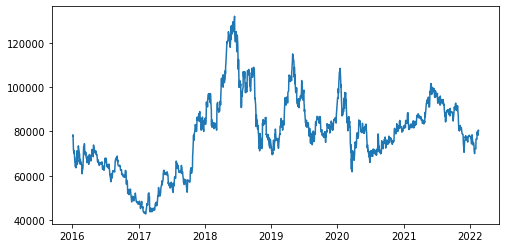

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 4))
plt.plot(data['Close'])    # 종가(Close) 데이터 그래프로 확인
plt.show()

In [3]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,79300.0,77400.0,77800.0,78100.0,287659.0,76103.640625
2016-01-05,78900.0,77400.0,78300.0,78500.0,236187.0,76493.414062
2016-01-06,79100.0,76500.0,78900.0,77300.0,370562.0,75324.085938
2016-01-07,78300.0,73200.0,77300.0,73500.0,856384.0,71621.226562
2016-01-08,72900.0,70600.0,72900.0,71600.0,797043.0,69769.796875


In [4]:
from sklearn.preprocessing import MinMaxScaler
# 데이터 정규화 : 모든 종가 데이터를 0-1사의 값으로 비율로 저장

scalar = MinMaxScaler(feature_range=(0, 1))

data_val = data.filter(['Close']).values 
scaled_data = scalar.fit_transform(data_val)

print(scaled_data)
print(len(scaled_data))

[[0.39573991]
 [0.40022422]
 [0.3867713 ]
 ...
 [0.42376682]
 [0.42152466]
 [0.42152466]]
1504


In [5]:
# train data length
import math
training_data_len = math.ceil(len(scaled_data)*0.8)

print(training_data_len)
print(1720*0.8)                 # 결과 확인 : 데이터의 80%

1204
1376.0


In [6]:
# set train data
train_data = scaled_data[0:training_data_len]
print("train data :", train_data)

train data : [[0.39573991]
 [0.40022422]
 [0.3867713 ]
 ...
 [0.43161435]
 [0.42825112]
 [0.41704036]]


In [7]:
# Append Past_SET to x_train

x_train = []
y_train = []

print(type(x_train))

<class 'list'>


In [8]:
# 훈련 데이터는 전체 중 0.8의 비중으로 한다.
# 아래 for루프는 LSTM에서 요구하는대로 formatting

# PAST_SET은 예측 날짜로부터 기억할 전날의 크기
# 예를들어, 30은 예측일로부터 30일 전까지의 데이터까지 모두 예측하는데 고려할 날
# --> LSTM의 '기억'이 30일

# PAST_SET = 300  # 계절성을 고려하여 약 1년 분량을 기억한다면? (220219)
PAST_SET = 30

In [9]:
for i in range(PAST_SET, len(train_data)):
    x_train.append(train_data[i-PAST_SET:i, 0])
    y_train.append(train_data[i, 0])


print(type(x_train))

x_train, y_train = np.array(x_train), np.array(y_train)  

print(type(x_train))

<class 'list'>
<class 'numpy.ndarray'>


In [10]:
print(x_train)
print(len(x_train))

[[0.39573991 0.40022422 0.3867713  ... 0.31053812 0.28587444 0.26793722]
 [0.40022422 0.3867713  0.3441704  ... 0.28587444 0.26793722 0.24887892]
 [0.3867713  0.3441704  0.32286996 ... 0.26793722 0.24887892 0.23766816]
 ...
 [0.43273543 0.42152466 0.42488789 ... 0.43049327 0.45627803 0.44730942]
 [0.42152466 0.42488789 0.42152466 ... 0.45627803 0.44730942 0.43161435]
 [0.42488789 0.42152466 0.41704036 ... 0.44730942 0.43161435 0.42825112]]
1194


In [11]:
print(y_train)
print(len(y_train))

[0.24887892 0.23766816 0.25       ... 0.43161435 0.42825112 0.41704036]
1194


In [12]:
# LSTM needs to get 3rd shape

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("x_train shape : ", x_train.shape)

# 훈련 데이터 셋의 차원 크기 : 2152개의 데이터가 각각 30일 전까지 포함, 뒤 1은 LSTM에서 요구하는 형태이다.

x_train shape :  (1194, 10, 1)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.3)) 
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.3)) 
model.add(Dense(1, activation='sigmoid'))    # 가중치에 음수가 있으므로 활성화 함수 종류는 큰 차이 없다
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                310       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [30]:
# Train
model.fit(x_train, y_train, batch_size=5, epochs=20)
# 배치 사이즈 및 에포크 변경하면서 학습 결과 모니터링(210224)

Epoch 1/20
239/239 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 2/20
239/239 [==============================] - 0s 1ms/step - loss: 0.0199
Epoch 3/20
239/239 [==============================] - 0s 1000us/step - loss: 0.0175
Epoch 4/20
239/239 [==============================] - 0s 1ms/step - loss: 0.0167
Epoch 5/20
239/239 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 6/20
239/239 [==============================] - 0s 1ms/step - loss: 0.0117
Epoch 7/20
239/239 [==============================] - 0s 1ms/step - loss: 0.0144
Epoch 8/20
239/239 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 9/20
239/239 [==============================] - 0s 1ms/step - loss: 0.0078
Epoch 10/20
239/239 [==============================] - 0s 992us/step - loss: 0.0087
Epoch 11/20
239/239 [==============================] - 0s 997us/step - loss: 0.0095
Epoch 12/20
239/239 [==============================] - 0s 1ms/step - loss: 0.0082
Epoch 13/20
239/23

In [31]:
test_data = scaled_data[(training_data_len - PAST_SET):, :]

x_test = []
y_test = scaled_data[training_data_len:, :]

print(y_test)
print(test_data)
print(len(test_data))
print(len(y_test))

[[0.42825112]
 [0.43946188]
 [0.44618834]
 [0.43609865]
 [0.43273543]
 [0.43161435]
 [0.46860987]
 [0.46748879]
 [0.47309417]
 [0.44394619]
 [0.44282511]
 [0.44282511]
 [0.43609865]
 [0.43946188]
 [0.4293722 ]
 [0.42152466]
 [0.41367713]
 [0.42713004]
 [0.41928251]
 [0.43049327]
 [0.44282511]
 [0.44618834]
 [0.44170404]
 [0.4338565 ]
 [0.44843049]
 [0.44955157]
 [0.43721973]
 [0.47309417]
 [0.46860987]
 [0.47197309]
 [0.47197309]
 [0.45852018]
 [0.46524664]
 [0.46076233]
 [0.47869955]
 [0.50784753]
 [0.51233184]
 [0.47869955]
 [0.45852018]
 [0.44843049]
 [0.42713004]
 [0.4293722 ]
 [0.43161435]
 [0.43161435]
 [0.43161435]
 [0.43946188]
 [0.45403587]
 [0.44058296]
 [0.44058296]
 [0.43609865]
 [0.43946188]
 [0.43946188]
 [0.4573991 ]
 [0.44282511]
 [0.45067265]
 [0.47085202]
 [0.44955157]
 [0.45515695]
 [0.43497758]
 [0.44394619]
 [0.46524664]
 [0.46860987]
 [0.4573991 ]
 [0.44955157]
 [0.46412556]
 [0.4573991 ]
 [0.45403587]
 [0.45964126]
 [0.49775785]
 [0.4955157 ]
 [0.49663677]
 [0.49

In [32]:
for i in range(PAST_SET, len(test_data)):
    x_test.append(test_data[i - PAST_SET:i, 0])

In [33]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)

In [34]:
# un scaling
predictions = scalar.inverse_transform(predictions)

In [35]:
print(predictions.shape)

(300, 1)


In [36]:
print(y_test.shape)

(300, 1)


In [37]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print("rmse : ", rmse)

# 평균 제곱 오차 계산 : 값의 크기에 따라 예측 결과 평가

rmse :  87238.55319226456


In [38]:
data = data.filter(['Close'])

train = data[:training_data_len]
valid = data[training_data_len : ]
valid['Predictions'] = predictions

#print("valid : ", valid)
valid.tail()

<ipython-input-38-8c0cfdfb29ba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,Close,Predictions
Date,,
2022-02-14,78800.0,77105.539062
2022-02-15,78300.0,78333.148438
2022-02-16,80600.0,79123.437500
2022-02-17,80400.0,74219.625000
2022-02-18,80400.0,75654.632812


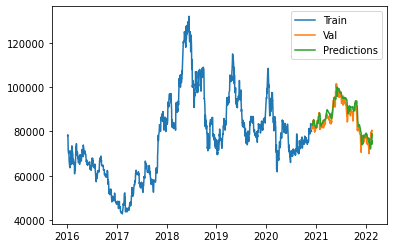

In [39]:
### plt.figure(figsize=(8, 4))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

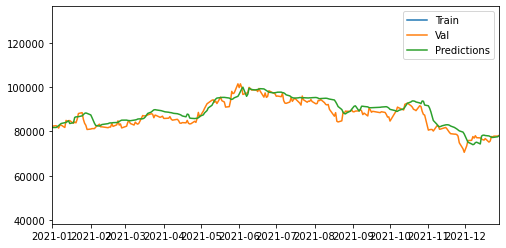

In [40]:
plt.figure(figsize=(8, 4))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])

x_min = datetime.datetime(2021, 1, 1)
x_max = datetime.datetime(2021, 12, 28)
plt.xlim(x_min, x_max)

plt.show()

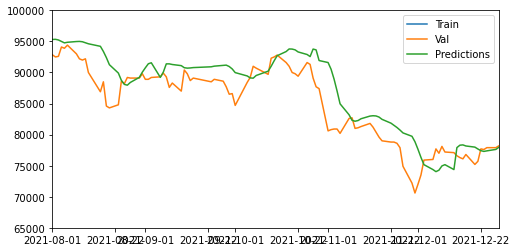

In [41]:
plt.figure(figsize=(8, 4))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])

x_min = datetime.datetime(2021, 8, 1)
x_max = datetime.datetime(2021, 12, 28)
plt.xlim(x_min, x_max)
plt.ylim(65000, 100000)

plt.show()

In [27]:
### 예측 그래프를 확대해보면, 전일 결과의 shift 형태라고 할 수 있다.
# 이는 예측이라 보기 힘들다 --> 손실을 줄이기 위해 바로 전 날의 값을 그대로 결과 값으로 출력한 듯